<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/topology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Algebraic Topology**

## **Introduction**

**A typical workflow is:**

1. **Create a point cloud** out of a finite dataset using a specific metric (Transform time series into point cloud by Taken's embedding, approach is based on [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem)).

2. **Construct a simplicial complex** via triangulation or a family of simplicial complex via filtration (construct a filtered cell complex from the point set S approximating the topology of X), typically via Čech Complex & Vietoris-Rips complex to get connected components

3. **Identify the most stabile invariant(s)** by increasing the ε ball monitoring the birth and death of connected components (during filtration) in a persistent diagram (topologically characterize this complex using topological invariants. The computed invariants then provide information about the underlying space X from which the data is assumed to have been sampled) - Create persistent barcode. Transform barcode into persistent diagram. Transform diagram into persistent landscape. Compute betti numbers as most stabile invariants

## **Libraries**

**General Libraries**

In [0]:
# General Data Science Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import networkx as nx
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

**Topology Libraries**

In [0]:
# Scikit TDA: Ripser, Kepler Mapper, Persim, (CechMate) & TaDAsets
# More: https://scikit-tda.org/libraries.html#libraries
!pip install scikit-tda --quiet
import tadasets
import kmapper
import ripser
from ripser import ripser
from ripser import Rips
from persim import plot_diagrams
import persim

In [0]:
# Cechmate https://cechmate.scikit-tda.org/notebooks/BasicUsage.html
!pip install cechmate --quiet
import cechmate as cm

In [0]:
# Simplicial: Simplicial topology in Python
# More: https://simplicial.readthedocs.io/en/latest/
!pip install simplicial --quiet
from simplicial import *

In [0]:
# Giotto: TDA library
!pip install giotto-learn --quiet
!pip install -U giotto-tda --quiet
import gtda.time_series as ts
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.pipeline import Pipeline
from gtda.plotting import plot_diagram, plot_point_cloud

## **Examples**

### **Tadaset**

Utilities for creating and loading various synthetic data sets with particular topological features and various levels of noise and dimension for Topological Data Analysis:

* n-spheres,
* torus,
* swiss rolls, and
* figure 8s.

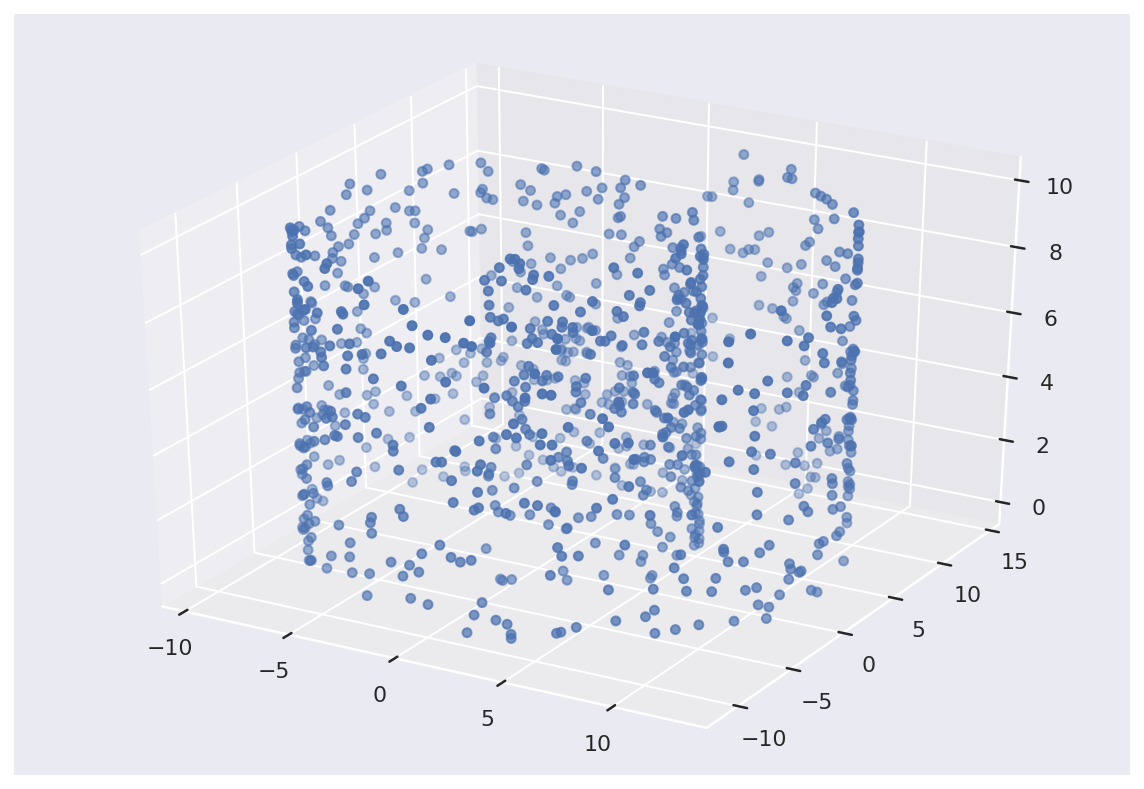

In [0]:
sns.set(rc={'figure.figsize':(10, 7)})
data = tadasets.swiss_roll(n=1000)
tadasets.plot3d(data)

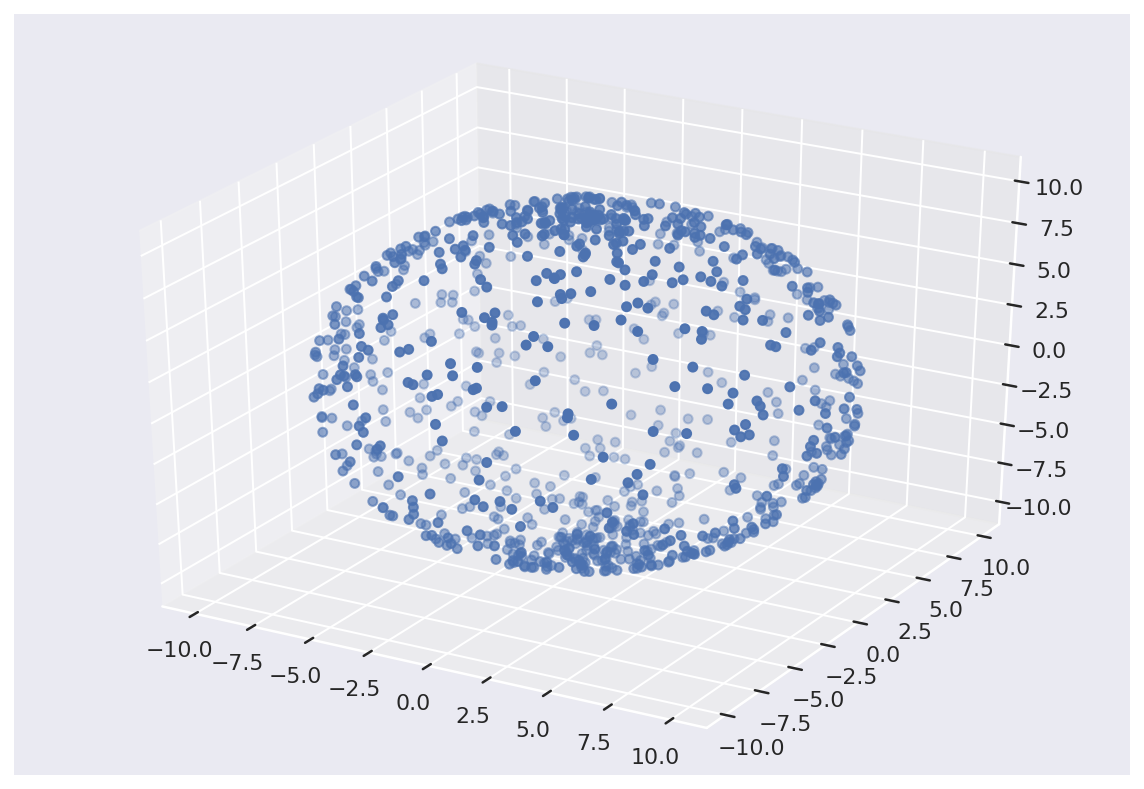

In [0]:
sns.set(rc={'figure.figsize':(10, 7)})
data = tadasets.sphere(n=1000, r=10)
tadasets.plot3d(data)

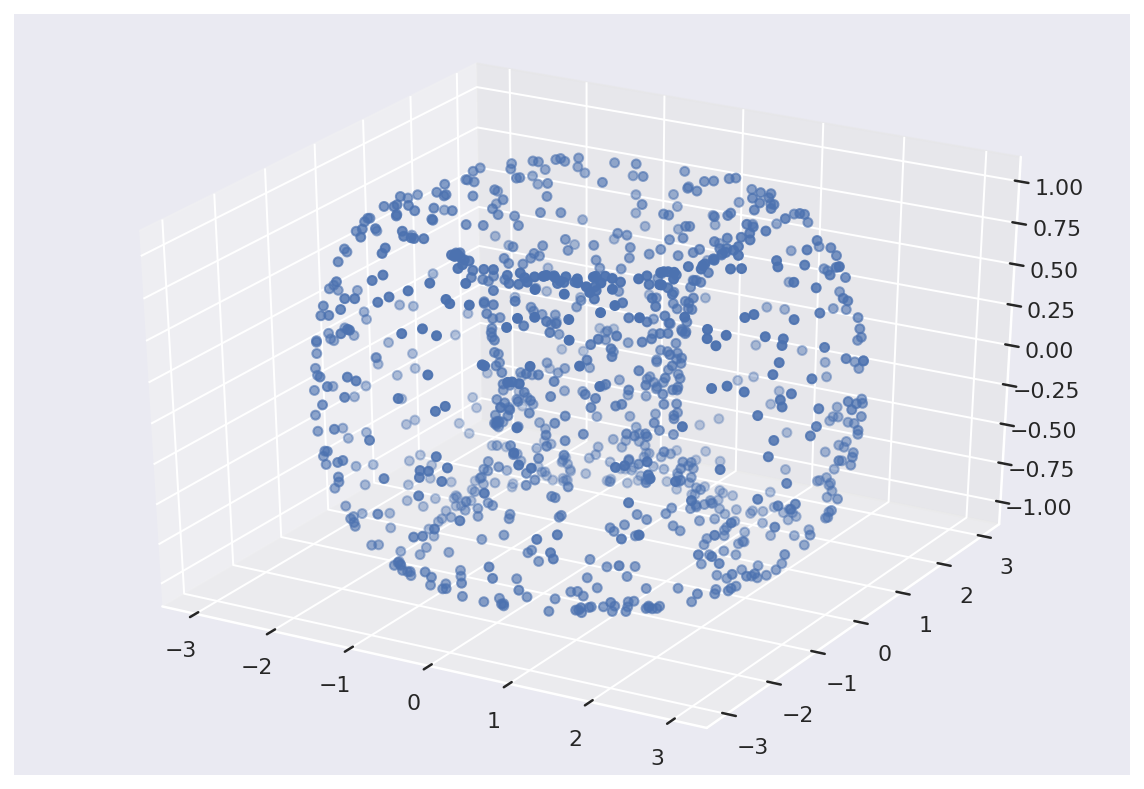

In [0]:
sns.set(rc={'figure.figsize':(10, 7)})
data = tadasets.torus(n=1000)
tadasets.plot3d(data)

### **Ripser**

Ripser.py is a persistent homology package for Python:

* computing persistence cohomology of sparse and dense data sets,
* visualizing persistence diagrams,
* computing lowerstar filtrations on images, and
* computing representative cochains.

https://ripser.scikit-tda.org/notebooks/Basic%20Usage.html

see also for time series: https://ripser.scikit-tda.org/notebooks/Lower%20Star%20Time%20Series.html

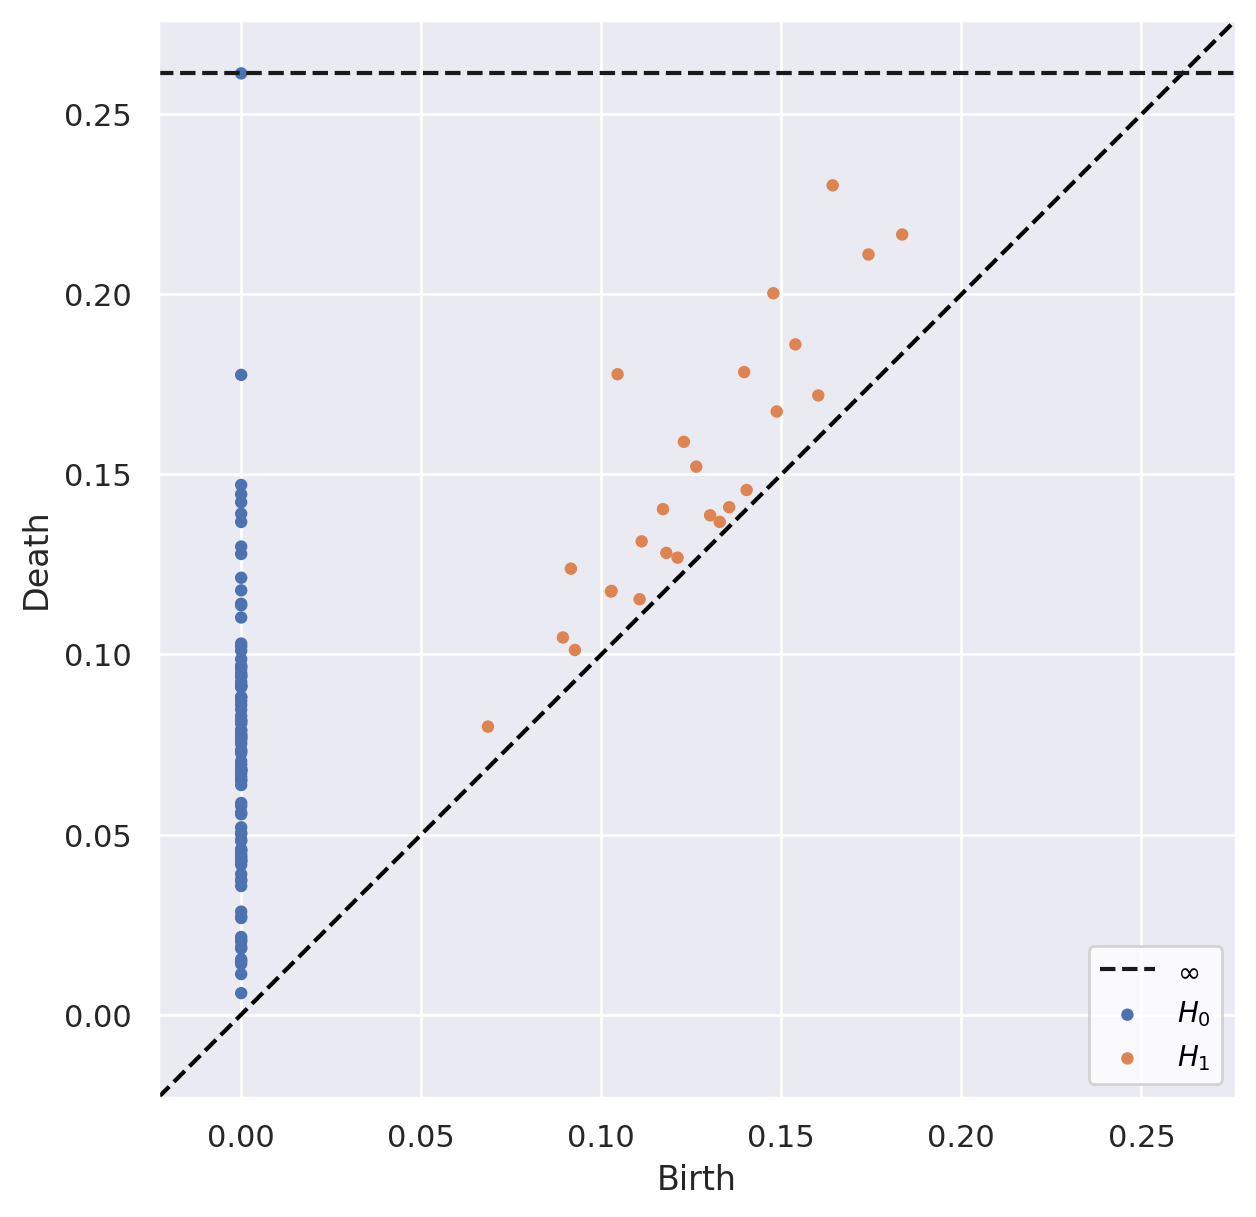

In [0]:
sns.set(rc={'figure.figsize':(10, 7)})
data = np.random.random((100,2))
diagrams = ripser(data)['dgms']
plot_diagrams(diagrams, show=True)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


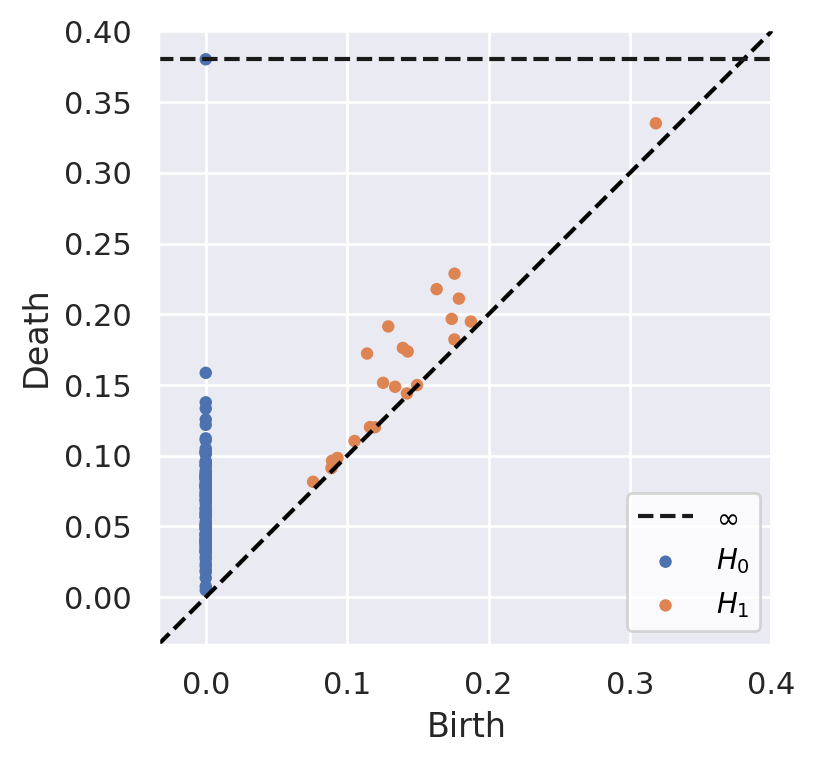

In [0]:
sns.set(rc={'figure.figsize':(7, 4)})
rips = Rips()
data = np.random.random((100,2))
diagrams = rips.fit_transform(data)
# rips.plot(diagrams)
plot_diagrams(diagrams, show=True)

### **Persim**

Once diagrams are constructed, the Persim package comes into play. This package houses many methods for comparison and analysis of persistence diagrams. It currently houses implementations of

* Persistence Images
* Diagram distances (Bottleneck distance, Modified Gromov–Hausdorff distance, Sliced Wasserstein Kernel, Heat Kernel)
* Diagram plotting / visualization

Modified Gromov–Hausdorff distance


In [0]:
data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
data_noisy = tadasets.dsphere(d=1, n=100, noise=0.1)

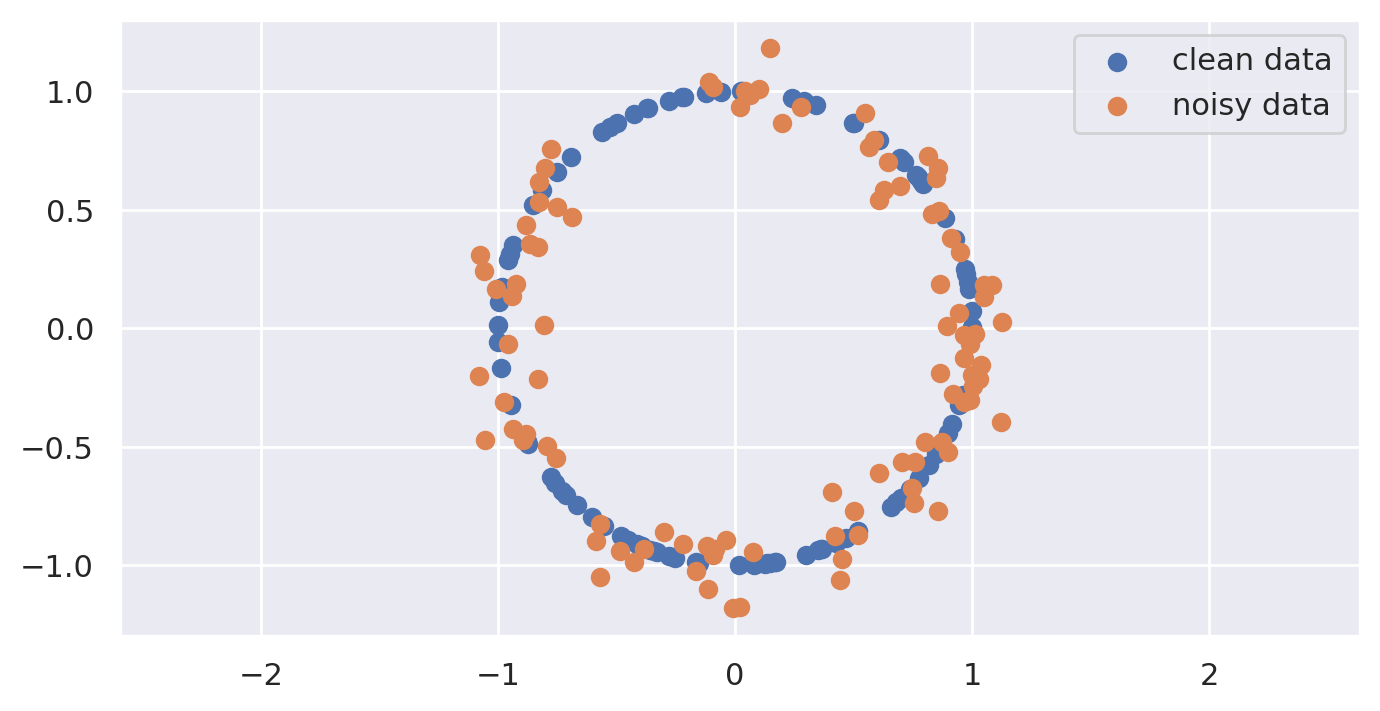

In [0]:
sns.set(rc={'figure.figsize':(8, 4)})
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data")
plt.scatter(data_noisy[:,0], data_noisy[:,1], label="noisy data")
plt.axis('equal')
plt.legend()
plt.show()

**Generate H1 diagrams for each of the data sets**

In [0]:
dgm_clean = ripser.ripser(data_clean)['dgms'][1]
dgm_noisy = ripser.ripser(data_noisy)['dgms'][1]

In [0]:
ripser.plot_dgms([dgm_clean, dgm_noisy] , labels=['Clean $H_1$', 'Noisy $H_1$'])

**Compute and visualize Bottleneck distance**

The bottleneck function has the option of returning the matching when the parameter matching is set to True. With the returned data, we can use the plot.bottleneck_matching function to visualize which persistence points contributed to the distance.

In [0]:
distance_bottleneck, (matching, D) = persim.bottleneck(dgm_clean, dgm_noisy, matching=True)

In [0]:
persim.plot.bottleneck_matching(dgm_clean, dgm_noisy, matching, D, labels=['Clean $H_1$', 'Noisy $H_1$'])

**Sliced Wasserstein distance**

Sliced Wasserstein Kernels for persistence diagrams were introduced by Carriere et al, 2017 and implemented by Alice Patania. The general idea is to compute an approximation of the Wasserstein distance by computing the distance in 1-dimension repeatedly, and use the results as measure. To do so, the points of each persistence diagram are projected onto M lines that pass through (0,0) and forms an angle theta with the axis x.

In [0]:
persim.sliced_wasserstein(dgm_clean, dgm_noisy)

0.40241825795894587

The parameter M controls the number of iterations to run

In [0]:
Ms = range(5, 100, 2)
ds = [persim.sliced_wasserstein(dgm_clean, dgm_noisy, M=M) for M in Ms]

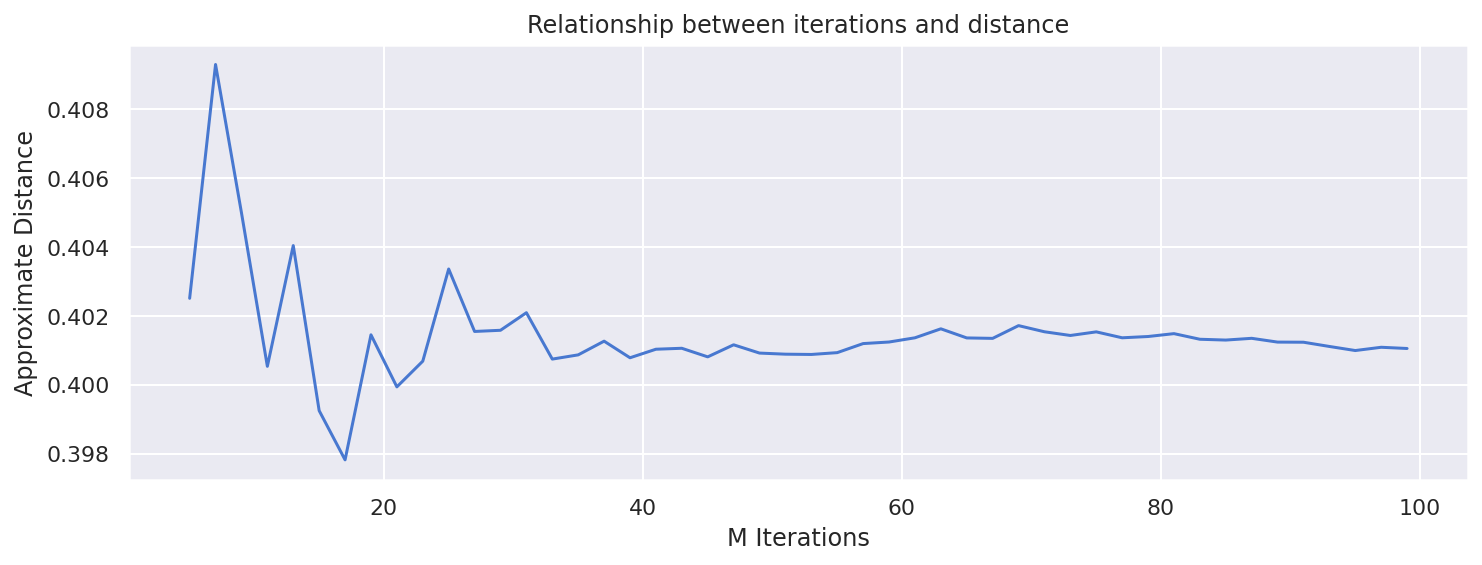

In [0]:
plt.plot(Ms, ds)
plt.xlabel("M Iterations")
plt.ylabel("Approximate Distance")
plt.title("Relationship between iterations and distance")
plt.show()

**Various levels of noise**

In this example, we will simulate various levels of noise and compute the distances from the clean circle

In [0]:
data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
dgm_clean = ripser.ripser(data_clean)['dgms'][1]

In [0]:
dists = []
noise_levels = np.linspace(0.0, 0.9, 30)
samples = 15

dists_bottleneck=[]
dists_sliced=[]

for n in noise_levels:
    for i in range(samples):
        ds_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
        dgm_clean = ripser.ripser(ds_clean)['dgms'][1]

        ds = tadasets.dsphere(d=1, n=100, noise=n)
        dgm = ripser.ripser(ds)['dgms'][1]

        dists_bottleneck.append((n, persim.bottleneck(dgm_clean, dgm)))
        dists_sliced.append((n, persim.sliced_wasserstein(dgm_clean, dgm)))

dists_sliced = np.array(dists_sliced)
dists_bottleneck = np.array(dists_bottleneck)

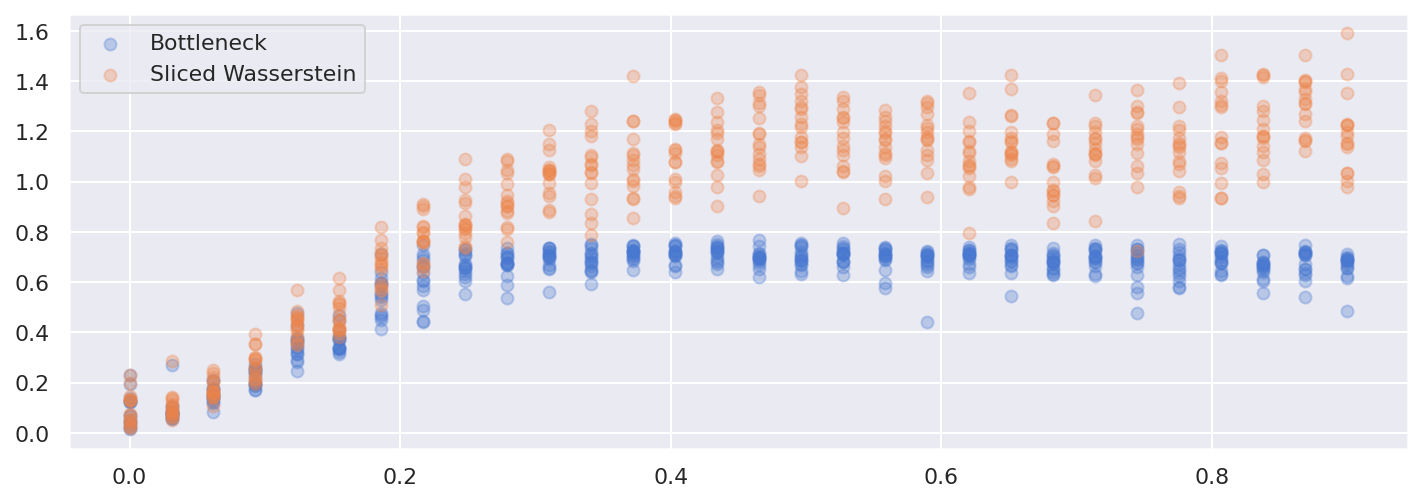

In [0]:
plt.scatter(dists_bottleneck[:,0], dists_bottleneck[:,1], label="Bottleneck", alpha=0.3)
plt.scatter(dists_sliced[:,0], dists_sliced[:,1], label="Sliced Wasserstein", alpha=0.3)
plt.legend()

### **Cechmate**

Constructors for custom filtrations that are suitable for use with Phat. Phat provides a clean interface for persistence reduction algorithms for boundary matrices. This tool helps bridge the gap between data and boundary matrices. Supports construction of

* Alpha filtrations,
* Rips filtrations, and
* Cech filtrations, and
* provide an easy interface for Phat.

**Rips Filtrations**

In [0]:
# Initialize a noisy circle
X = tadasets.dsphere(n=100, d=1, r=1, noise=0.2)

In [0]:
# Instantiate and build a rips filtration
max_dim = 1
rips = cm.Rips(max_dim) #Go up to 1D homology
rips.build(X)
dgmsrips = rips.diagrams()

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 2.4)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 1)


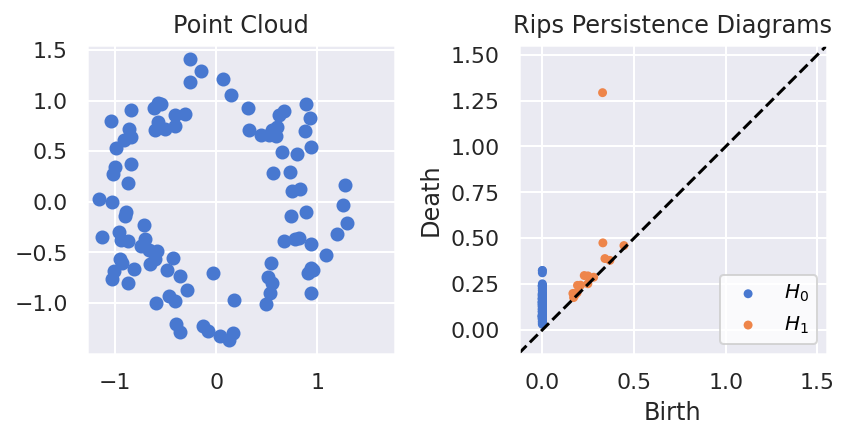

In [0]:
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1])
plt.axis('square')
plt.title("Point Cloud")
plt.subplot(122)
plot_diagrams(dgmsrips)
plt.title("Rips Persistence Diagrams")
plt.tight_layout()
plt.show()

**Cech Filtrations**

In [0]:
cech = cm.Cech(max_dim) #Go up to 1D homology
cech.build(X)
dgmscech = cech.diagrams() * 2

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 2.41)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 1.18)


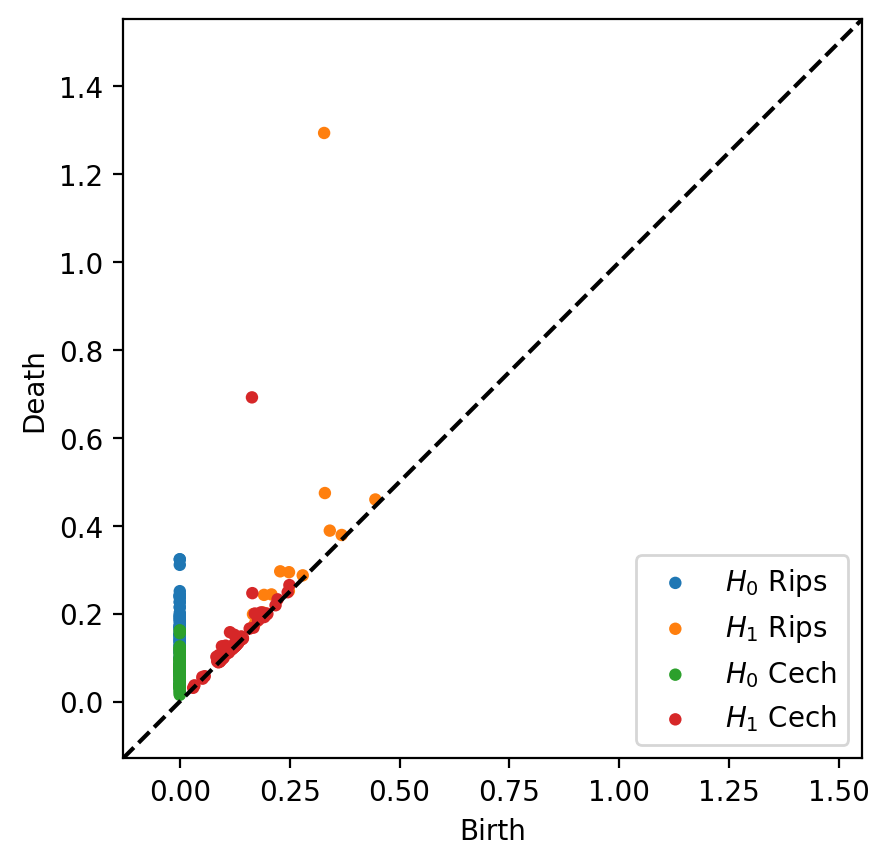

In [0]:
plot_diagrams(dgmsrips + dgmscech, labels = ['$H_0$ Rips', '$H_1$ Rips', '$H_0$ Cech', '$H_1$ Cech'])
plt.show()

**Alpha Filtrations**

Now we will perform an alpha filtration on the exact same point cloud.

In [0]:
alpha = cm.Alpha()
filtration = alpha.build(2*X) # Alpha goes by radius instead of diameter
dgmsalpha = alpha.diagrams(filtration)

Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.00746)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.0503)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.00703)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.00085)


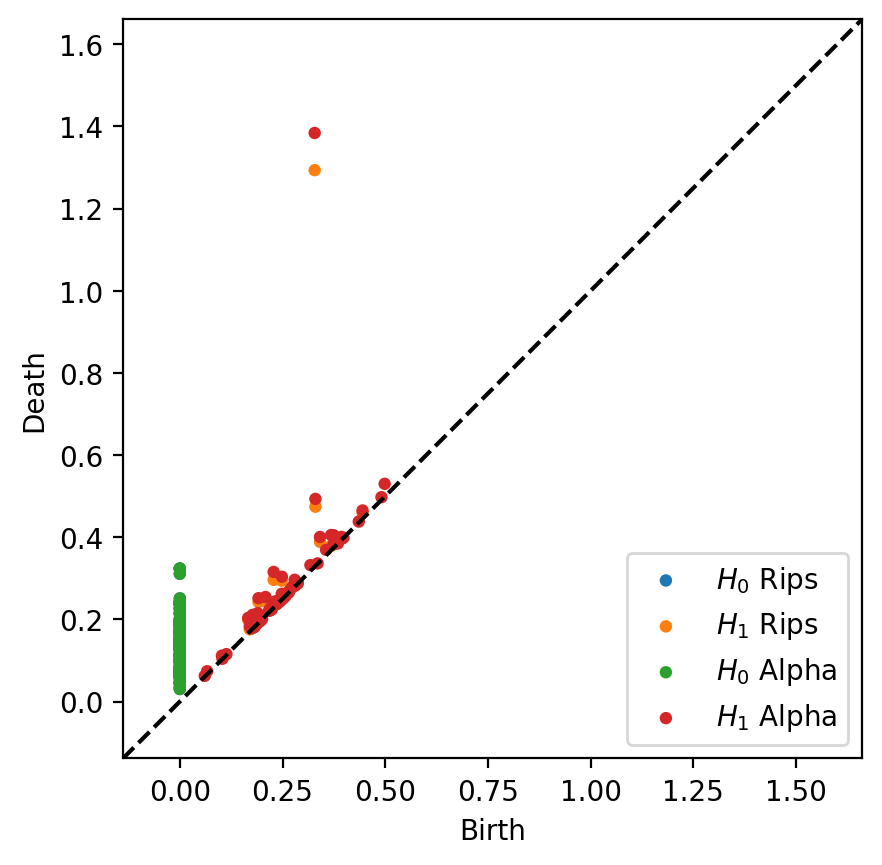

In [0]:
plot_diagrams(dgmsrips + dgmsalpha, labels = ['$H_0$ Rips', '$H_1$ Rips', '$H_0$ Alpha', '$H_1$ Alpha'])
plt.show()

Note that the alpha filtration is substantially faster than the Rips filtration, and it is also more geometrically accurate. In rips, we add a triangle the moment its edges are added, but growing balls around their vertices do not necessarily cover the triangle at that point, as they are in the Cech filtration. Alpha is the intersection of Cech balls with Voronoi regions, so it is a strict subset of Cech. Hence, it takes a larger scale to add triangles, so the classes die slightly later. Now let’s try an example with a 400 points sampled from a 4-sphere in 5 dimensions.

Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 1.06)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 101)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 2.31)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.252)


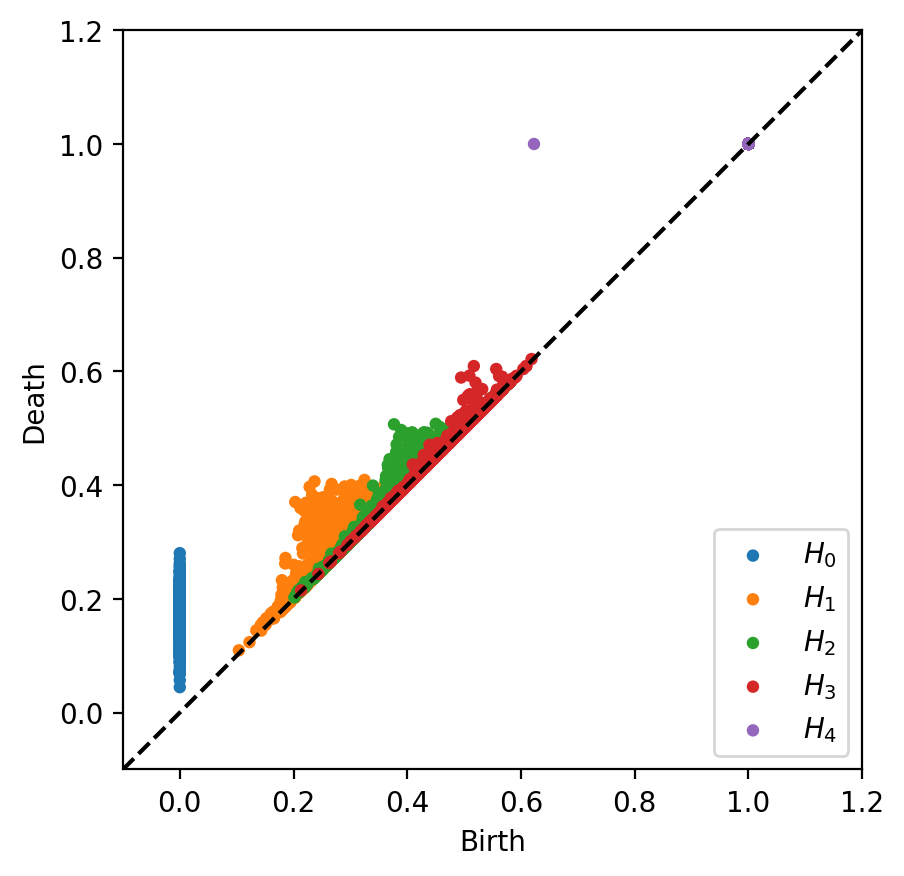

In [0]:
X = tadasets.dsphere(n=400, r=1, d=4)

alpha = cm.Alpha()
filtration = alpha.build(X)
dgms = alpha.diagrams(filtration)
plot_diagrams(dgms)
plt.show()

As expected, the only nontrivial homology is in H4. Normally computing H4 with that number of points would grind Rips to a halt, but it runs in a reasonable amount of time with Alpha. The bottleneck with Alpha is constructing the filtration and computing many circumcenters. Note that computing the persistence pairs takes even less time than H1 for Rips with only 100 points shown above.

**Custom Filtration**

If you have a point cloud and a set of simplices with times at which they are added, you can compute the persistence diagrams associated to the custom filtration you’ve defined. For instance, assume we want to compute a filtration where 4 vertices enter at time 0 and the edges and triangles are added in the pattern below (note how the triangles are not added the moment all of their edges are added, unlike Rips):

In [0]:
filtration = [([0], 0),
            ([1], 0),
            ([2], 0),
            ([3], 0),
            ([0, 1], 1),
            ([0, 2], 1),
            ([1, 2], 2),
            ([0, 1, 2], 4),
            ([0, 3], 2),
            ([2, 3], 3),
            ([0, 2, 3], 6)]
#Compute persistence diagrams
dgms = cm.phat_diagrams(filtration, show_inf = True)
print("H0:\n", dgms[0])
print("H1:\n", dgms[1])

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.000147)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.000401)
H0:
 [[ 0.  1.]
 [ 0.  1.]
 [ 0.  2.]
 [ 0. inf]]
H1:
 [[2 4]
 [3 6]]


### **Simplicial**

Simplicial is for creating, manipulating, and exploring simplicial complexes. It aims to provide a useful set of features for programmers and mathematicians while remaining scalable to deal with large complexes. “Large” here means a few-thousands of points and simplices: simplicial isn’t suitable for dealing with large image datasets or extremely high-dimensional spaces, which require more advanced programming techniques.

https://simplicial.readthedocs.io/en/latest/tutorial/build-complex.html

In [0]:
c = SimplicialComplex()

These lines all add 0-simplices – points – to the complex. The SimplicialComplex.addSimplex() method returns the name of the simplex added, which will either be the one given in its id argument or a synthetic one if no name is given explicitly. We can then build 1-simplices – lines – by providing two 0-simplices as endpoints:

In [0]:
# add a simplex with a generated name
s1 = c.addSimplex()

# add simplices whose names we want to specify
s2 = c.addSimplex(id = 2)
s3 = c.addSimplex(id = 3)

The fs (“faces”) argument names each face of the higher simplex. A 1-simplex (a line, a one-dimensional structure) has two 0-simplices (points, 0-dimensional structures) as faces. A 2-simplex (a triangle, a 2-dimensional structure) has three 1-simplices (lines) as faces:

In [0]:
l23 = c.addSimplex(fs = [ 2, 3 ])

So adding a new k-simplex requires providing (k + 1) (k - 1)-simplices as faces. SimplicialComplex.addSimplex() checks to make sure that the right nmumber of faces, of the right order, are provided.

If you just want a new simplex of a given order, entirely disjoint from the other simplices in the complex, you can create one:

In [0]:
# txyz = c.addSimplexOfOrder(2, id = 'xyz')

This will create all the necessary simplices: 1 2-simplex (a triangle), three 1-simplices (the edges), and 3 0-simplices (the vertices), all with unique names. (In this case we provided a name for the triangle.)

A k-simplex has $(k + 1) 0-simplices as its vertices, referred to as its basis. We can create a simplex directly by specifying its basis:

In [0]:
s5 = c.addSimplex(id = 5)
s6 = c.addSimplex(id = 6)
l56 = c.addSimplex(fs = [ s5, s6 ])

tabc = c.addSimplexWithBasis(bs = [ s3, s5, s6 ], id = 'abc')

Like SimplicialComplex.addSimplexOfOrder(), SimplicialComplex.addSimplexWithBasis() will add any simplices that are needed but that don’t already exist in the complex: in the example above, in order to cvreate the triangle abc it would need to create lines between s3 and s5 and between s3 and s6, but could use the existing line between s5 and s6 as the third face. (This works because there can be at most one simplex with a given basis.) SimplicialComplex.addSimplexWithBasis() will raise an exception if a simplex with this basis already exists, unless its optional ignoreDuplicate argument is set to True whereupon the duplicate simples will be silently ignored.

Simplices can be deleted from a complex very simply:

In [0]:
c.deleteSimplex(s5)

Deleting s5 would remove part of the basis for the triangle tabc as well as the endpoint for two of its faces, and these simplices will automatically be deleted as well.

Important
Deleting a simplex will delete all the simplices of which it is part. This implies that deleting a simplex may delete other simplices of higher orders than itself. The exact simplices deleted can be found using SimplicialComplex.partOf().

### **KeplerMapper**

https://kepler-mapper.scikit-tda.org/notebooks/Adapters.html

In [0]:
data = datasets.make_circles(n_samples=1000)[0]

In [0]:
km = kmapper.KeplerMapper()
lens = km.project(data)
graph = km.map(X=data, lens=lens)

In [0]:
nx_graph = kmapper.adapter.to_nx(graph)

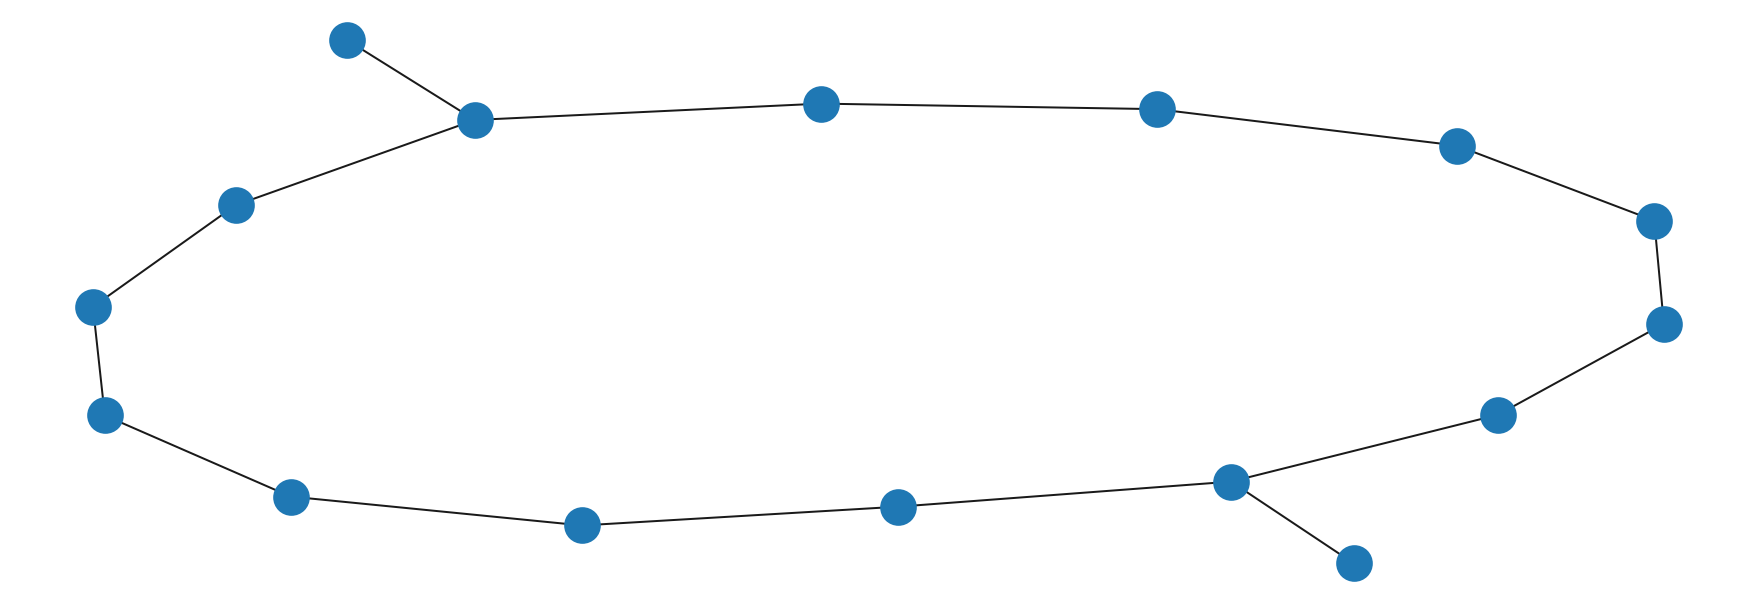

In [0]:
nx.draw(nx_graph)

# **Introduction into TDA for Time Series**

## **Data Import**

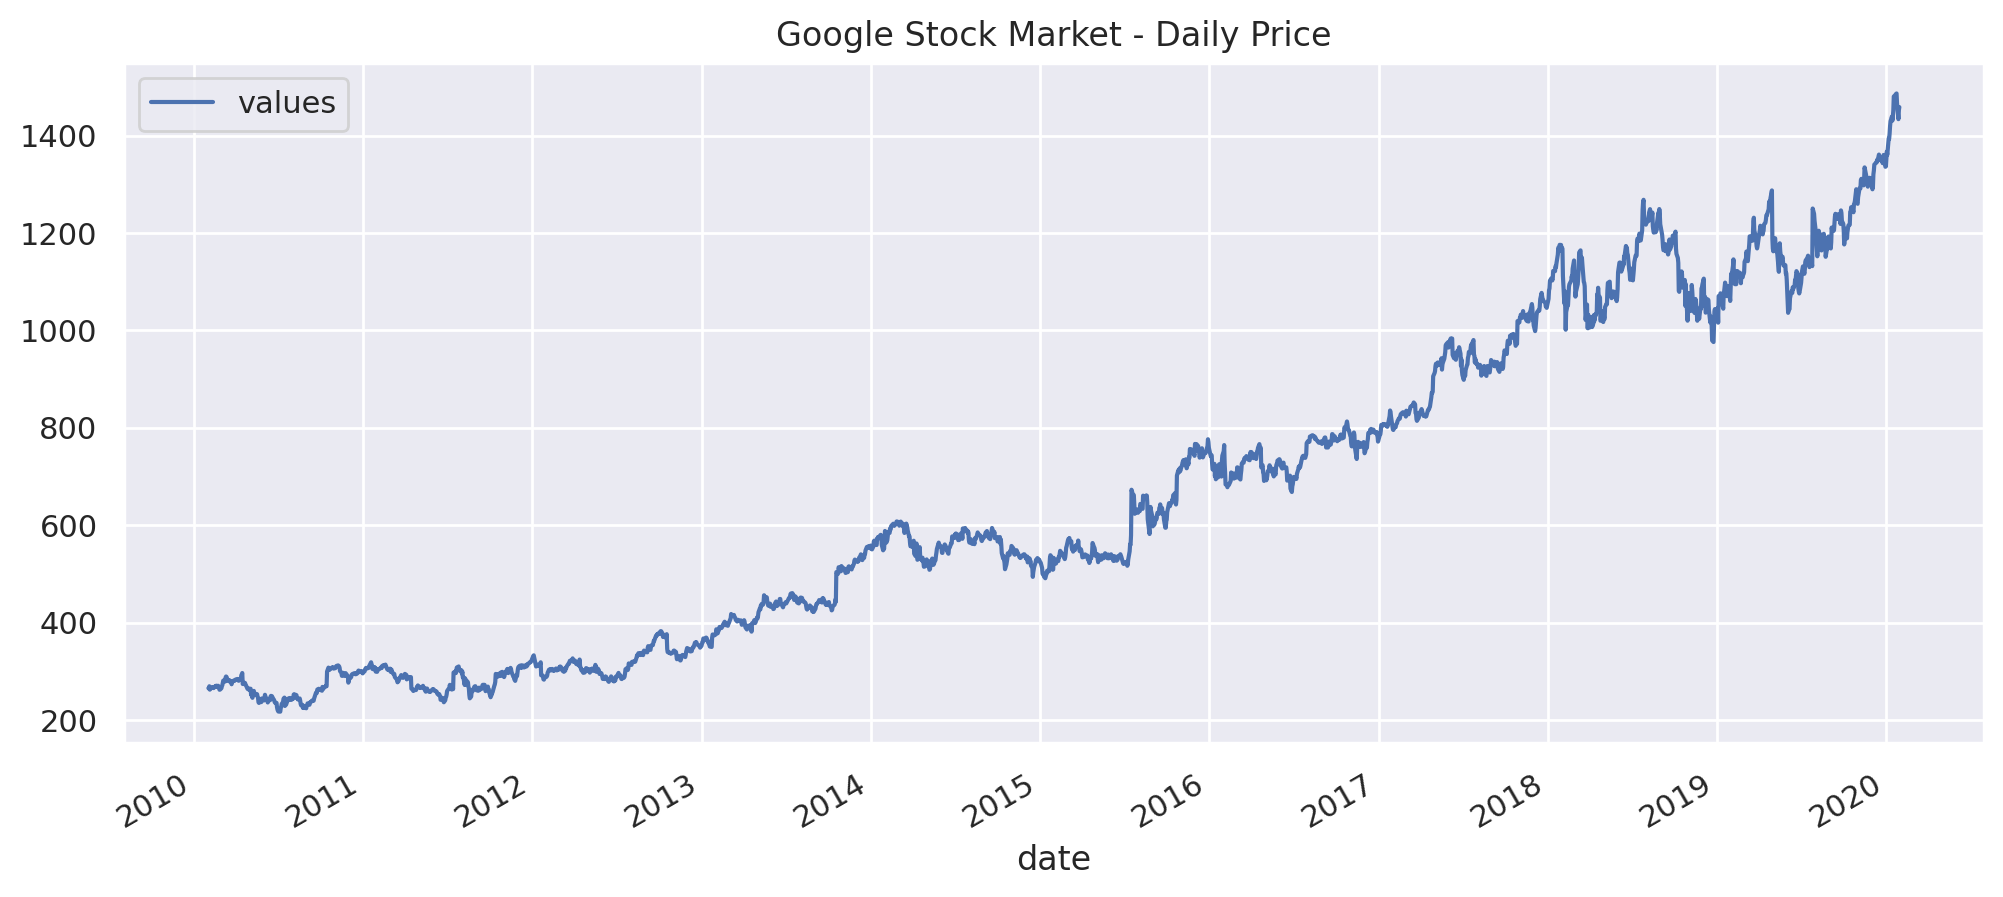

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
series = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "values"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)

sns.set(rc={'figure.figsize':(12, 5)})

series.plot(title='Google Stock Market - Daily Price')

In [0]:
# Add edges between adjacent points in the time series, with the "distance"
# along the edge equal to the max value of the points it connects
I = np.arange(N-1)
J = np.arange(1, N)
V = np.maximum(x[0:-1], x[1::])
# Add vertex birth times along the diagonal of the distance matrix
I = np.concatenate((I, np.arange(N)))
J = np.concatenate((J, np.arange(N)))
V = np.concatenate((V, x))
#Create the sparse distance matrix
D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
dgm0 = ripser(D, maxdim=0, distance_matrix=True)['dgms'][0]
dgm0 = dgm0[dgm0[:, 1]-dgm0[:, 0] > 1e-3, :]
allgrid = np.unique(dgm0.flatten())
allgrid = allgrid[allgrid < np.inf]
xs = np.unique(dgm0[:, 0])
ys = np.unique(dgm0[:, 1])
ys = ys[ys < np.inf]

#Plot the time series and the persistence diagram
plt.figure(figsize=(12, 6))
ylims = [-1, 6.5]
plt.subplot(121)
plt.plot(t, x)
ax = plt.gca()
ax.set_yticks(allgrid)
ax.set_xticks([])
plt.ylim(ylims)
plt.grid(linewidth=1, linestyle='--')
plt.title("$\\cos(2 \pi t) + t$")
plt.xlabel("t")

plt.subplot(122)
ax = plt.gca()
ax.set_yticks(ys)
ax.set_xticks(xs)
plt.ylim(ylims)
plt.grid(linewidth=1, linestyle='--')
plot_diagrams(dgm0, size=50)
plt.title("Persistence Diagram")


plt.show()

## **Point Clouds**

Approach is based on [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem)

In [0]:
embedding_dimension = 3
embedding_time_delay = 2

In [0]:
embedder = ts.TakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

In [0]:
price_values = series.values
price_embedded = embedder.fit_transform(price_values)

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

In [0]:
window_width = 30
window_stride = 4

In [0]:
sliding_window = ts.SlidingWindow(width=window_width, stride=window_stride)
price_embedded_windows = sliding_window.fit_transform(price_embedded)

In [0]:
window_num = 100
point_cloud = price_embedded_windows[window_num][:, :3]
plot_point_cloud(point_cloud)

## **Persistence Diagram**

Missing: Visualization of Simplicial complex & Persistence Barcode

In [0]:
# define the number of homology dimensions to track
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=1)

# Fit into a persistent diagram
diagrams = VR.fit_transform(price_embedded_windows)

In [0]:
plot_diagram(diagrams[window_num])

# **Example from Giotto**

## **Homological derivatives**

In [0]:
from gtda.utils.validation import *

# from gtda.utils.validation import check_diagram,
# from gtda.utils.validation import validate_params
# from gtda.utils.validation import validate_metric_params

In [0]:
from gtda.utils.validation import validate_params

In [0]:
from gtda.utils.validation import check_diagrams

In [0]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):
        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])
        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = (
                np.concatenate(Xt).reshape(len(self.homology_dimensions_), len(X) - 1).T
            )
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

## **Landscape distances**

https://github.com/giotto-ai/stock-market-crashes/blob/master/Stock%20Market%20Crash%20Detection.ipynb

https://towardsdatascience.com/detecting-stock-market-crashes-with-topological-data-analysis-7d5dd98abe42

In [0]:
metric_params = {"p": 2, "n_layers": 20, "n_bins": 1000} # "n_values": 1000

landscape_hom_der = HomologicalDerivative(
    metric="landscape", metric_params=metric_params, order=2, n_jobs=1,
)
landscape_succ_dists = landscape_hom_der.fit_transform(diagrams)

Text(0.5, 1.0, 'Landscape Distances for Google')

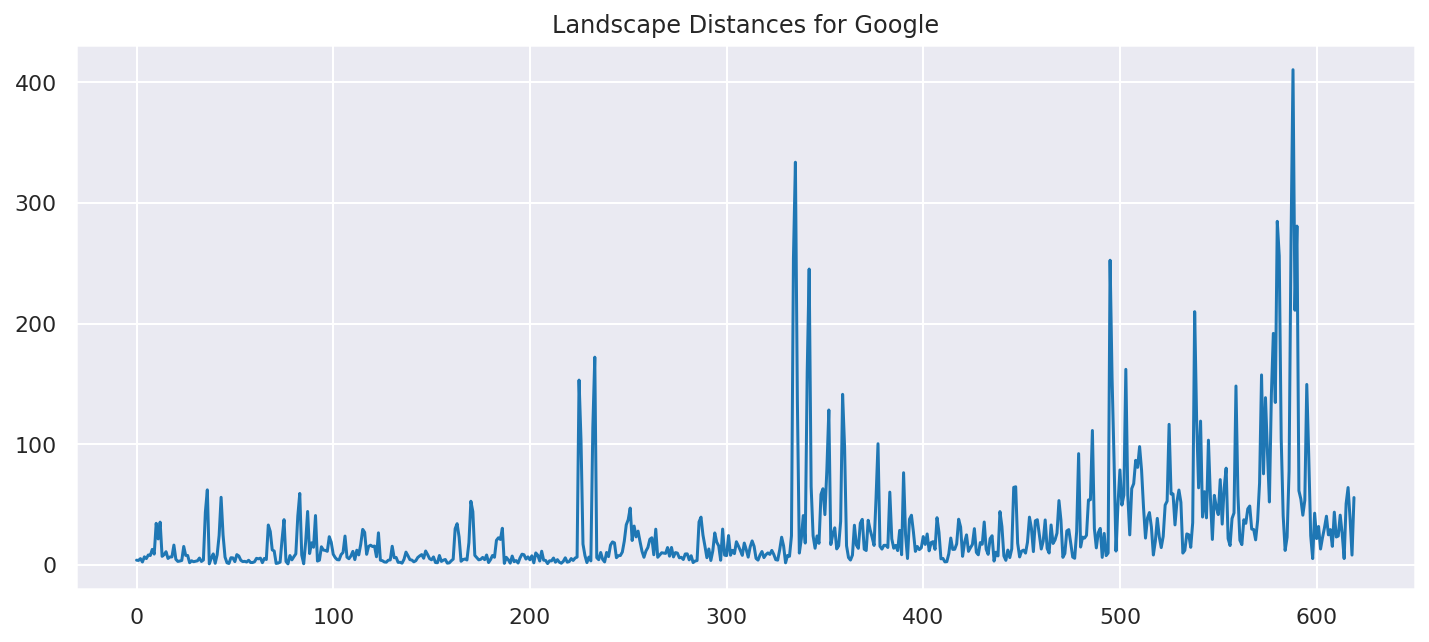

In [0]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(landscape_succ_dists, color="#1f77b4")
plt.title("Landscape Distances for Google")